In [388]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix, hstack, vstack, linalg
import numpy.matlib
import pandas as pd
import matplotlib.patches as patches
import matplotlib.colors as colors

In [209]:
Node,Element,NodeBC=PolyMesher(16)

In [326]:
fem_NNode = Node.shape[0]    # Number of nodes
fem_NElem = Element.shape[0] # Number of elements
fem_Node = Node           # [NNode x 2] array of nodes
fem_Element = Element     # [NElement x Var] cell array of elements
fem_NodeBC = NodeBC       # Array of velocity boundary conditions
fem_mu0 = 1               # Dynamic viscosity
fem_Reg = 0               # Tag for regular meshes
R = -1
Volfrac = 1
P_ori = np.identity(fem_NElem)
P = csr_matrix(P_ori)

In [327]:
#zIni = np.load('Lshape_16/sol_sort_16.npy')
zIni = np.ones(P.shape[0])*Volfrac

In [328]:
opt_zMin=0.0    # Lower bound for design variables
opt_zMax=1.0    # Upper bound for design variables
opt_zIni = zIni # Initial design variables
opt_P = P       # Matrix that maps design to element vars.
opt_VolFrac = Volfrac  # Specified volume fraction cosntraint
opt_Tol = 0.01   # Convergence tolerance on design vars.
opt_MaxIter = 150  # Max. number of optimization iterations
opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

In [329]:
Tol=opt_Tol*(opt_zMax-opt_zMin)
Change=2*Tol
z=opt_zIni
P=opt_P

In [330]:
E,dEdy,V,dVdy = MatIntFnc(P*z,np.array([fem_mu0,0.01]))

In [331]:
g,dgdE,dgdV,fem_ElemArea = ConstraintFnc(fem_NElem,fem_Node,fem_Element,E,V,Volfrac)

In [342]:
fem_ElemNDofA = (2*fem_Element.shape[1])*np.ones(fem_Element.shape[0])
fem_iA = np.zeros(int(sum(fem_ElemNDofA**2)))
fem_jA=np.zeros(int(sum(fem_ElemNDofA**2)))
fem_kAmu=np.zeros(int(sum(fem_ElemNDofA**2))) 
fem_kAalpha=np.zeros(int(sum(fem_ElemNDofA**2)))
fem_e=np.zeros(int(sum(fem_ElemNDofA**2)))
fem_iB = np.zeros(int(sum(fem_ElemNDofA)))
fem_jB=np.zeros(int(sum(fem_ElemNDofA)))
fem_kB=np.zeros(int(sum(fem_ElemNDofA)))
fem_NDof = (2*fem_NNode+fem_NElem+1)
indexA = 0
indexB = 0
fem_ShapeFnc_W,fem_ShapeFnc_N,fem_ShapeFnc_dNdxi = TabShapeFnc(4)
for el in range(fem_NElem):  
    eNode = fem_Element[el,:]
    eNDof = int(fem_ElemNDofA[el])
    if el==0:
        Amu_e,Aalpha_e,Be=LocalK(fem_mu0,fem_ShapeFnc_W,fem_ShapeFnc_dNdxi,fem_ShapeFnc_N,fem_Node,eNode)
    eDofA = np.concatenate([(2*eNode).reshape(4,1),(2*eNode+1).reshape(4,1)],axis=1).reshape(eNDof,1)
    I=np.matlib.repmat(eDofA ,1,eNDof)
    J=I.T
    fem_iA[indexA:indexA+eNDof**2] = I.T.flatten()
    fem_jA[indexA:indexA+eNDof**2] = J.T.flatten()
    fem_kAmu[indexA:indexA+eNDof**2] = Amu_e.flatten()
    fem_kAalpha[indexA:indexA+eNDof**2] = Aalpha_e.flatten()
    fem_e[indexA:indexA+eNDof**2] = el
    fem_iB[indexB:indexB+eNDof] = eDofA.flatten()
    fem_jB[indexB:indexB+eNDof] = el
    fem_kB[indexB:indexB+eNDof] = Be.flatten()
    indexA = indexA + eNDof**2
    indexB = indexB + eNDof
fem_FixedDofs = np.zeros((1,fem_NodeBC.shape[0]))
fem_G = np.zeros((fem_NodeBC.shape[0],1))
for i in range(fem_NodeBC.shape[0]):
    fem_FixedDofs[0,i] = 2*(fem_NodeBC[i,0]) + fem_NodeBC[i,1]
    fem_G[i] = fem_NodeBC[i,2]
fem_FreeDofs = np.setdiff1d(np.arange(fem_NDof),fem_FixedDofs)
A = csr_matrix((fem_kAmu+E[fem_e.astype(int)]*fem_kAalpha,(fem_iA.astype(int),fem_jA.astype(int))))
B = csr_matrix((fem_kB,(fem_iB.astype(int),fem_jB.astype(int))))
Z=np.zeros((2*fem_NNode,1))
O=csr_matrix((fem_NElem,fem_NElem),dtype='int')
K_1 = hstack([A,B,Z])
K_2 = hstack(([B.T,O,csr_matrix(fem_ElemArea.reshape(fem_ElemArea.shape[0],1))]))
K_3 = hstack([Z.T,csr_matrix(fem_ElemArea),0])
K = vstack([K_1,K_2,K_3])
K = (K+K.transpose())/2
S = np.zeros((fem_NDof,1)) 
S[fem_FixedDofs.astype(int),:]=fem_G

S[fem_FreeDofs,:] = linalg.spsolve(K[fem_FreeDofs,:][:,fem_FreeDofs], \
                                   -K[fem_FreeDofs.flatten(),:][:,fem_FixedDofs.flatten()]*S[fem_FixedDofs.astype(int),:].flatten())[:,np.newaxis]
U = S[:2*fem_NNode]
p=S[2*fem_NNode:]
F = A*U
f = 1/2*np.dot(F.flatten(),U.flatten())
print(f)

7.3861475876543405


In [333]:
u_plot = np.zeros(int(U.shape[0]/2))
v_plot = np.zeros(int(U.shape[0]/2))
for i in range(u_plot.shape[0]):
    u_plot[i] = U[2*i]
    v_plot[i] = U[2*i+1]
u_plot_elem = np.zeros(fem_NElem)
v_plot_elem = np.zeros(fem_NElem)
for i in range(fem_NElem):
    u_plot_elem[i] = np.mean(u_plot[Element[i,:]]);
    v_plot_elem[i] = np.mean(v_plot[Element[i,:]])

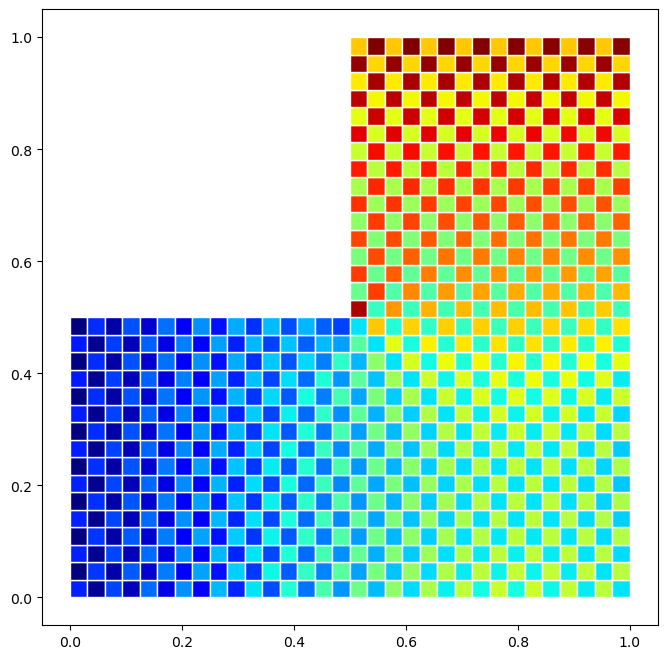

In [540]:
p_plot=p
#p_plot=u_plot_elem**2+v_plot_elem**2
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
cm = plt.get_cmap("jet")
max_p = max(p_plot)
min_p = min(p_plot)
for i in range(fem_NElem):
    c_ind = (p_plot[i]-min_p)/(max_p-min_p)
    r = patches.Rectangle(xy=fem_Node[int(fem_Element[i,0])]/2, width=1/32, height=1/32, fc=colors.rgb2hex(cm(c_ind)),ec='w')
    ax.add_patch(r)
    plt.axis('scaled')
    ax.set_aspect('equal')

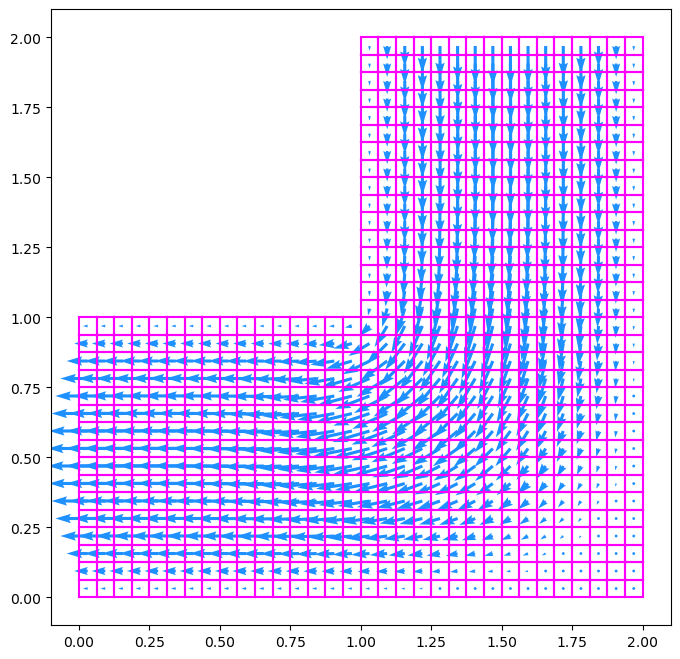

In [447]:
Node_T=Node.T
centr = np.zeros((2,fem_NElem))
for i in range(fem_NElem):
    centr[0,i]=np.mean(Node_T[0,Element[i,:]])
    centr[1,i]=np.mean(Node_T[1,Element[i,:]])
plt.figure(figsize=(8,8))
for temp_t in Element:
    plt.plot([Node_T[0,temp_t[0]],Node_T[0,temp_t[1]]],[Node_T[1,temp_t[0]],Node_T[1,temp_t[1]]],color='magenta')
    plt.plot([Node_T[0,temp_t[1]],Node_T[0,temp_t[2]]],[Node_T[1,temp_t[1]],Node_T[1,temp_t[2]]],color='magenta')
    plt.plot([Node_T[0,temp_t[2]],Node_T[0,temp_t[3]]],[Node_T[1,temp_t[2]],Node_T[1,temp_t[3]]],color='magenta')
    plt.plot([Node_T[0,temp_t[3]],Node_T[0,temp_t[0]]],[Node_T[1,temp_t[3]],Node_T[1,temp_t[0]]],color='magenta')

#for i in range(len(NodeBC)):
    #plt.scatter(Node[int(NodeBC[i,0]),0],Node[int(NodeBC[i,0]),1],color = 'dodgerblue')
for i in range(fem_NElem):
    plt.quiver(centr[0,i], centr[1,i], u_plot_elem[i], v_plot_elem[i],angles='xy', scale_units='xy', scale=7, width=0.005,color='dodgerblue')
    #plt.scatter(centr[0,i], centr[1,i])

In [515]:
det=[]
for i in range(A.toarray().shape[0]):
    det.append(np.linalg.det((A.toarray()[:i+1,:i+1])/3))
    

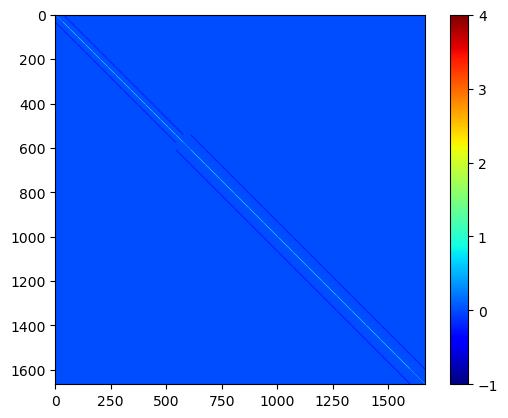

In [534]:
plt.imshow(A.toarray(),cmap='jet')
plt.colorbar()
#det[1598:]

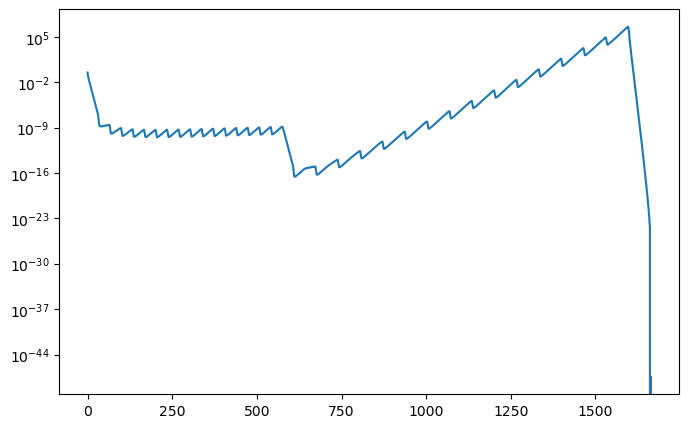

In [517]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(A.toarray().shape[0]),det)
# plt.xscale("log")
plt.yscale("log")
#plt.xlim(0,100)
#plt.ylim(10**0,9.99*10**265)


In [445]:
def LocalK(fem_mu0,fem_ShapeFnc_W,fem_ShapeFnc_dNdxi,fem_ShapeFnc_N,fem_Node,eNode):
    Cmu = fem_mu0*np.array([[2,0,0],[0,2,0],[0,0,1]])
    nn=eNode.shape[0]
    Amu_e=np.zeros((2*nn,2*nn))
    Aalpha_e=Amu_e
    Be=np.zeros(2*nn)
    W = fem_ShapeFnc_W
    for q in range(W.shape[0]):   #quadrature loop
        dNdxi = fem_ShapeFnc_dNdxi[:,:,q]
        J0 = np.dot(fem_Node[eNode,:].T,dNdxi)
        dNdx = np.dot(dNdxi,np.linalg.inv(J0))
        B = np.zeros((3,2*nn))
        B[0,[0,2,4,6]] = dNdx[:,0] 
        B[1,[1,3,5,7]] = dNdx[:,1] 
        B[2,[0,2,4,6]] = dNdx[:,1] 
        B[2,[1,3,5,7]] = dNdx[:,0]
        Amu_e = Amu_e +(np.dot(np.dot(B.T,Cmu),B)*W[q]*np.linalg.det(J0))
        N = fem_ShapeFnc_N[:,:,q]
        Nu = np.zeros((2,2*nn))
        Nu[0,[0,2,4,6]] = N.reshape(4)
        Nu[1,[1,3,5,7]] = N.reshape(4)
        Aalpha_e = Aalpha_e + np.dot(np.dot(Nu.T,Nu),W[q])*np.linalg.det(J0)
        dNudx = dNdx.reshape(2*nn)
        Be = Be - (dNudx.T)*W[q]*np.linalg.det(J0)
    return Amu_e,Aalpha_e,Be

In [176]:
def TabShapeFnc(nn):
    W,Q = PolyQuad(nn)            #🫠
    fem_ShapeFnc_W = W
    fem_ShapeFnc_N = np.zeros((nn,1,W.shape[0]))
    fem_ShapeFnc_dNdxi = np.zeros((nn,2,W.shape[0]));
    for q in range(W.shape[0]):
        N,dNdxi = PolyShapeFnc(nn,Q[q,:])
        fem_ShapeFnc_N[:,:,q] = N.reshape(4,1) 
        fem_ShapeFnc_dNdxi[:,:,q] = dNdxi
    return fem_ShapeFnc_W,fem_ShapeFnc_N,fem_ShapeFnc_dNdxi

In [177]:
def PolyShapeFnc(nn,xi):
    N=np.zeros(nn)
    alpha=np.zeros(nn)
    dNdxi=np.zeros((nn,2)) 
    dalpha=np.zeros((nn,2))
    sum_alpha=0.0
    sum_dalpha=np.zeros((1,2))
    A=np.zeros(nn)
    dA=np.zeros((nn,2))
    p,Tri = PolyTrnglt(nn,xi)
    for i in range(nn):
        sctr = Tri[i,:].astype(int)
        pT = p[sctr,:]
        A[i] = 1/2*np.linalg.det(np.concatenate((pT,np.ones((3,1))),axis=1))
        dA[i,0] = 1/2*(pT[2,1]-pT[1,1])
        dA[i,1] = 1/2*(pT[1,0]-pT[2,0])
    dA = dA[[3,0,1,2,3],:]        #🫠
    A = A[[3,0,1,2,3]]
    for i in range(nn):
        alpha[i] = 1/(A[i]*A[i+1])
        dalpha[i,0] = -alpha[i]*(dA[i,0]/A[i]+dA[i+1,0]/A[i+1])
        dalpha[i,1] = -alpha[i]*(dA[i,1]/A[i]+dA[i+1,1]/A[i+1])
        sum_alpha += alpha[i]
        sum_dalpha[0,:] += dalpha[i,:]
    for i in range(nn):
        N[i] = alpha[i]/sum_alpha
        dNdxi[i,:] = (dalpha[i,:]-N[i]*sum_dalpha[:])/sum_alpha
    return N,dNdxi

In [178]:
def PolyQuad(nn):    
    W = np.array([1/6,1/6,1/6])
    Q = np.array([1/6,1/6,2/3,1/6,1/6,2/3]).reshape(3,2)
    p,Tri = PolyTrnglt(nn,[0,0])
    point=np.zeros(((W.shape)[0]*nn,2))
    weight=np.zeros((W.shape)[0]*nn)
    for k in range(nn):
        sctr = (Tri[k,:]).astype(int)
        for q in range(W.shape[0]):
            N,dNds = TriShapeFnc(Q[q,:])
            J0 = np.dot(p[sctr,:].T,dNds)
            l = k*(W.shape[0]) + q
            point[l,:] = np.dot(N.T,p[sctr,:])
            weight[l] = np.linalg.det(J0)*W[q]
    return weight, point

In [179]:
def PolyTrnglt(nn,xi):
    p = np.zeros((nn+1,2))
    for i in range(nn):
        p[i,:] = np.cos(2*np.pi*(i+1)/nn), np.sin(2*np.pi*(i+1)/nn)
    p[-1,:] = xi
    Tri = np.zeros((nn,3))
    Tri[:,0]=nn
    Tri[:,1]=np.arange(nn) 
    Tri[:,2]=np.arange(nn)+1
    Tri[nn-1,2]=0
    return p,Tri

In [180]:
def TriShapeFnc(s):
    N=np.array([1-s[0]-s[1],s[0],s[1]]).T
    dNds=np.array([[-1,-1],[1,0],[0,1]])
    return N,dNds

In [181]:
def ConstraintFnc(fem_NElem,fem_Node,fem_Element,E,V,Volfrac):
    fem_ElemArea = np.zeros(fem_NElem)
    for el in range(fem_NElem):
        vx = fem_Node[fem_Element[el,:],0]
        vy = fem_Node[fem_Element[el,:],1]
        vx_s = vx[[1,2,3,0]]                        #🫠
        vy_s = vy[[1,2,3,0]]
        fem_ElemArea[el] = 0.5*sum(vx*vy_s-vy*vx_s)
    g = sum(fem_ElemArea*V)/sum(fem_ElemArea)-Volfrac
    dgdE = np.zeros(E.shape)
    dgdV = fem_ElemArea/sum(fem_ElemArea)
    return g,dgdE,dgdV,fem_ElemArea

In [182]:
def PolyMesher(nelm):
    dx = 1/nelm
    dy = dx
    nnode = (nelm+1)*(3*nelm+1)
    Node = np.zeros((nnode,2))
    x = 0
    for i in range(nelm):
        y = 0
        for j in range(nelm+1):
            ind = i*(nelm+1)+j
            Node[ind,:] = np.array([x,y])
            y = y+dy
        x = x+dx
    for i in range(nelm+1):
        y = 0
        for j in range(2*nelm+1):
            ind = nelm*(nelm+1)+i*(2*nelm+1)+j
            Node[ind,:] = np.array([x,y])
            y = y+dy
        x = x+dx
    elmN = nelm*nelm*3
    conec = np.zeros((elmN,4))
    ind = 0
    for i in range((nelm+1)*nelm):
        if i%(nelm+1)!=nelm:
            conec[ind,:] = i,int(i+nelm+1), int(i+nelm+2), int(i+1)
            ind = ind+1
    for i in range((2*nelm+1)*nelm):
        j = i+(nelm+1)*nelm
        if i%(2*nelm+1)!=2*nelm:
            conec[ind,:] = int(j),int(j+2*nelm+1),int(j+2*nelm+2),int(j+1)
            ind = ind+1
    Element = conec.astype(int)
    NodeBC = BoundaryCnd(nelm,Node)
    return Node, Element, NodeBC

def BoundaryCnd(nelm,Node):
    BC=[]
    for i in range(nelm):
        BC.append([(i+1)*(nelm+1),0,0])
        BC.append([(i+1)*(nelm+1),1,0])
        BC.append([(i+1)*(nelm+1)+nelm,0,0])
        BC.append([(i+1)*(nelm+1)+nelm,1,0])
        BC.append([(nelm+1)*nelm+(i+1)*(2*nelm+1),0,0])
        BC.append([(nelm+1)*nelm+(i+1)*(2*nelm+1),1,0])
    for i in range(nelm-1):
        BC.append([(nelm+1)*(nelm+1)+i,0,0])
        BC.append([(nelm+1)*(nelm+1)+i,1,0])
    for i in range(nelm*2-1):
        BC.append([(nelm+1)*nelm+(2*nelm+1)*nelm+1+i,0,0])
        BC.append([(nelm+1)*nelm+(2*nelm+1)*nelm+1+i,1,0])
    for i in range(nelm+1):
        v_x = -(1-4*(1/2-Node[i,1])**2)
        BC.append([i,0,v_x])
        BC.append([i,1,0])
        v_y = -(1-4*(3/2-Node[(nelm+1)*nelm+(2*nelm+1)*(i+1)-1,0])**2)
        BC.append([(nelm+1)*nelm+(2*nelm+1)*(i+1)-1,0,0])
        BC.append([(nelm+1)*nelm+(2*nelm+1)*(i+1)-1,1,v_y])
    BC.sort()
    NodeBC = np.array(BC)
    return NodeBC
def MatIntFnc(y,param):
    mu0 = param[0]
    q = param[1]
    epsilon = 4*(10**-5)
    E = (mu0/epsilon)*q*(1-y)/(y+q)
    dEdy = -(mu0/epsilon)*(1+q)*q/((y+q)**2)
    V = y
    dVdy = np.ones(y.shape[0])
    return E,dEdy,V,dVdy